In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
import random
import pickle
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

2023-06-12 19:05:16.374937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 19:05:16.483444: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-12 19:05:16.487127: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2023-06-12 19:05:16.487140: I tensorflow/compiler/xla/stream_executor/cuda/cudart

In [2]:
def get_targets_with_weights(batch_data, initial_ensembles, size_ens, ann): 
    
    target_dim = 1
    
    weights_ann_1 = ann.get_weights()
    
    h1  = ann.layers[1].output.shape[-1]

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [3]:
def ann(hidden = 32, input_shape = 256, output_shape = 1): 
    input_layer = tf.keras.layers.Input(shape = (input_shape))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(output_shape, activation = "relu")
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [4]:
def generate_initial_ensembles(num_weights, lambda1, size_ens):
    mean_vec = np.zeros((num_weights,))
    cov_matrix = lambda1*np.identity(num_weights)
    mvn_samp = mvn(mean_vec, cov_matrix)
    return mvn_samp.rvs(size_ens)

In [5]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [6]:
hidden_neurons = 8

In [7]:
def get_initial_X_t(data1, data2, size_ens, var_weights = 2.0):
    samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    
    initial_ensembles1 = generate_initial_ensembles(samp_ann.count_params(), var_weights, size_ens)
    data1_out1, data1_stack1 = get_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens, ann = samp_ann)
    
    initial_ensembles2 = generate_initial_ensembles(samp_ann.count_params(), var_weights, size_ens)
    data1_out2, data1_stack2 = get_targets_with_weights(data1, initial_ensembles2, size_ens = size_ens, ann = samp_ann)
    
    initial_ensembles3 = generate_initial_ensembles(samp_ann.count_params(), var_weights, size_ens)
    data2_out1, data2_stack1 = get_targets_with_weights(data2, initial_ensembles3, size_ens = size_ens, ann = samp_ann)
    
    initial_ensembles4 = generate_initial_ensembles(samp_ann.count_params(), var_weights, size_ens)
    data2_out2, data2_stack2 = get_targets_with_weights(data2, initial_ensembles4, size_ens = size_ens, ann = samp_ann)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles_for_weights = generate_initial_ensembles(4, var_weights, size_ens)
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    initial_ensembles_for_L = generate_initial_ensembles(4, var_weights, size_ens)
    initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)    
    
    initial_ensembles_for_D1 = generate_initial_ensembles(1, var_weights, size_ens).reshape(-1,1)
    initial_ensembles_for_D2 = generate_initial_ensembles(1, var_weights, size_ens).reshape(-1,1)
    
    initial_ensembles_for_D1_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    initial_ensembles_for_D2_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
    initial_ensembles_for_D = np.concatenate((np.expand_dims(initial_ensembles_for_D1,1),
                                                       np.expand_dims(initial_ensembles_for_D1_zero,1), 
                                                      np.expand_dims(initial_ensembles_for_D2,1),
                                                       np.expand_dims(initial_ensembles_for_D2_zero,1)), axis = 2)
    
    # print(X_t.shape, initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D), axis = 1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4))
    
    return X_t, initial_ensembles, initial_ensembles_for_weights[:,0,:], initial_ensembles_for_L[:,0,:], initial_ensembles_for_D[:,0,:]

In [8]:
def get_weighted_targets_with_weights(batch_data, initial_ensembles, size_ens, ann, weights): 
    
    target_dim = 1
    
    weights_ann_1 = ann.get_weights()
    
    h1  = ann.layers[1].output.shape[-1]

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    final_output_1 = final_output_1*weights
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [9]:
alogp_bottleneck = np.load("..//Data/small_mol_phase_3_features_for_both.npy")

In [10]:
y_valid = np.load('..//Data/smiles_0.7_rdkit_0.3_outputs.npy')

In [11]:
y_train = y_valid

In [12]:
std_targets = pickle.load( open('..//Data//target_scaler.pkl', 'rb'))

/home/statgrads/vpiyush2/.conda/envs/enkf/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [13]:
# y_train = y_valid.values[:,1:]

In [14]:
# y_train = std_targets.transform(y_train)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x_train, x_valid, y_train, y_valid = train_test_split(alogp_bottleneck, y_train, test_size = 0.25, shuffle = True, 
                                                     random_state = 42)

In [17]:
x_train.shape

(719, 64)

In [18]:
smiles_feats_train = x_train[:, :32]

In [19]:
rdkit_feats_train = x_train[:, 32:]

In [20]:
smiles_feats_valid = x_valid[:, :32]
rdkit_feats_valid = x_valid[:, 32:]

In [21]:
# size_ens = 250

In [22]:
def forward_operation(data1, data2, combined_ensembles , size_ens ):
    samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann.count_params()
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (4*params):(4*params + 4)]
    
    initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(4*params + 4 + 4):(4*params + 4 + 4 + 4)]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:,:2].sum(1).reshape(-1,1)
    
    model_2 = softmax_weights[:,2:].sum(1).reshape(-1,1)
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                 ann = samp_ann, weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data1, initial_ensembles2, size_ens = size_ens,
                                                                 ann = samp_ann, weights=model_1)
    
    data2_out1, data2_stack1 = get_weighted_targets_with_weights(data2, initial_ensembles3, size_ens = size_ens,
                                                                 ann = samp_ann, weights=model_2)
    
    data2_out2, data2_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles4, size_ens = size_ens,
                                                                 ann = samp_ann, weights=model_2)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4, 
                        initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D), axis = 1)
    
    weighted_alogp = data1_out1 + data2_out1
    
    weighted_psa = data1_out2 + data2_out2
    
    return X_t, initial_ensembles, weighted_alogp, weighted_psa, model_1, model_2

In [23]:
samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)

2023-06-12 19:05:19.133837: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2023-06-12 19:05:19.133859: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-12 19:05:19.133872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c2518.crane.hcc.unl.edu): /proc/driver/nvidia/version does not exist
2023-06-12 19:05:19.134042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
total_weights = 4*(samp_ann.count_params() + 1 + 1 + 1)

In [25]:
total_weights

1104

In [26]:
reduction = 4

In [27]:
size_ens = total_weights//reduction

In [28]:
size_ens

276

In [29]:
X_t, initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D = get_initial_X_t(smiles_feats_train, rdkit_feats_train, size_ens = size_ens)

In [30]:
# X_t, initial_ensembles, initial_ensembles_for_weights = get_initial_X_t(smiles_feats_train, rdkit_feats_train, size_ens = size_ens)

In [31]:
initial_ensembles = np.hstack((initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_L, initial_ensembles_for_D))

In [32]:
initial_ensembles.shape

(276, 1104)

In [33]:
G_t = [[1, 0, 1, 0], [0, 1, 0, 1]]
G_t = np.array(G_t).T

In [34]:
G_t

array([[1, 0],
       [0, 1],
       [1, 0],
       [0, 1]])

In [35]:
def get_predictions(data1, data2, initial_ensembles): 
    _,_, weighted_alogp, weighted_psa, w1, w2 = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens)
    weighted_alogp = np.expand_dims(weighted_alogp,-1)
    weighted_psa = np.expand_dims(weighted_psa,-1)
    preds = np.concatenate((weighted_alogp, weighted_psa),-1)
    return preds, w1, w2

In [36]:
# H_t = np.hstack((np.identity(smiles_feats_train.shape[0]), np.zeros((smiles_feats_train.shape[0], samp_ann.count_params() + 1 + 1 + 1))))

In [37]:
# H_t.shape

In [38]:
def calculate_mu_bar_G_bar(data1, data2, initial_ensembles):
    H_t = np.hstack((np.identity(data1.shape[0]), np.zeros((data1.shape[0], samp_ann.count_params() + 1 + 1 + 1))))
    mu_bar = initial_ensembles.mean(0)
    X_t,_, _, _, _, _ = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens)
    X_t = X_t.transpose((0,2,1))
    X_t = X_t.reshape(X_t.shape[0], X_t.shape[1]*X_t.shape[2])
    script_H_t = np.kron(G_t.T, H_t)
    G_u = (script_H_t@X_t.T)
    G_u = G_u.T
    # weighted_alogp = np.expand_dims(weighted_alogp,-1)
    # weighted_psa = np.expand_dims(weighted_psa,-1)
    # G_u = np.concatenate((weighted_alogp, weighted_psa), axis = -1)
    # G_u = G_u.transpose((0,2,1))
    # G_u = G_u.reshape(G_u.shape[0], G_u.shape[1]*G_u.shape[2])
    # G_u
    G_bar = (G_u.mean(0)).ravel()
    return mu_bar.reshape(-1,1), G_bar.reshape(-1,1), G_u

In [39]:
def calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u): 
    u_j_minus_u_bar = initial_ensembles - mu_bar.reshape(1,-1)
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    c = np.zeros((total_weights, G_bar.shape[0]))
    for i in range(0, size_ens): 
        c += np.kron(u_j_minus_u_bar[i, :].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return c/size_ens, G_u_minus_G_bar

In [40]:
def calculate_D_u( G_bar, G_u): 
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    d = np.zeros((G_bar.shape[0], G_bar.shape[0]))
    for i in range(0, size_ens): 
        d += np.kron(G_u_minus_G_bar[i,:].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return d/size_ens

In [41]:
# initial_ensembles.shape

In [42]:
def get_updated_ensemble(data1, data2, initial_ensembles, size_ens = size_ens):
    mu_bar, G_bar, G_u = calculate_mu_bar_G_bar(data1, data2, initial_ensembles)
    C, G_u_minus_G_bar = calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u)
    D = calculate_D_u( G_bar, G_u)
    _, R_t = create_cov(data1.shape[0],initial_ensembles)
    # all_covs = np.array(all_covs)
    D_plus_cov = D + R_t
    D_plus_cov_inv = np.linalg.inv(D_plus_cov)
    mid_quant = C@D_plus_cov_inv
    noise_vec_mean = np.zeros((R_t.shape[0], ))
    noise_mvn = mvn(noise_vec_mean, R_t)
    fudging = noise_mvn.rvs(size_ens)
    interim = (y_train.T.flatten().reshape(1,-1) + fudging)
    right_quant = interim - G_u
    # print(mid_quant.shape, right_quant.shape)
    mid_times_right = mid_quant@right_quant.T
    updated_ensemble = (initial_ensembles + mid_times_right.T)
    return updated_ensemble

In [43]:
# initial_ensembles[:, -8:-4].mean(0)

In [44]:
target_dim = 2

In [45]:
# initial_ensembles[:, -4:]

In [46]:
# tf.math.softplus(np.array([0.]).reshape(-1,1))

In [47]:
def create_cov(shape, initial_ensembles):
    cov_part = initial_ensembles[:, -8:-4]
    cov_part = cov_part.mean(0)
    # variances = tf.math.softplus(cov_part[:2]).numpy()
    variances = cov_part[:2]
    covariances = cov_part[2:]
    base_cov = np.identity(target_dim)
    base_cov[0,0] = variances[0]
    base_cov[1,1] = variances[1]
    base_cov[0,1] = covariances[0]
    base_cov[1,0] = covariances[1]
    
    variances1 = tf.math.softplus(initial_ensembles[:, -4:]).numpy()
    variances1 = variances1.mean(0)
    base_variances = np.identity(target_dim)
    base_variances[0,0] = variances1[0]
    base_variances[1,1] = variances1[2]
    
    final = np.linalg.cholesky(base_cov@base_cov.T + base_variances)
    cov_mat = final@final.T
    cov_mat_final = cov_mat
    # cov_mat_final = cov_mat@cov_mat.T
    
    if is_pos_def(cov_mat_final) != True:
        print("resulting cov matrix is not positive semi definite")
        pass
    
    # print(np.linalg.det(cov_mat_final))
    
    var1 = cov_mat_final[0,0]
    var2 = cov_mat_final[1,1]
    cov = cov_mat_final[1,0]

    n = shape
    
    ul = var1*np.identity(n)
    lr = var2*np.identity(n)
    ur = cov*np.identity(n)
    ll = ur.T    
    
    first_row = np.hstack((ul, ur))
    second_row = np.hstack((ll, lr))
    
    R_t = np.vstack((first_row, second_row))
    
    # R_t = block_diag(*([cov_mat_final] * n))
    
    # R_t = np.linalg.inv(R_t)
    
    return cov_mat_final, R_t
    

In [48]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [49]:
cov_mat_final, _ = create_cov(smiles_feats_train.shape[0],initial_ensembles)

In [50]:
cov_mat_final

array([[ 0.98260425, -0.01742697],
       [-0.01742697,  0.85291194]])

In [51]:
def inverse_transform(data, idx):
    data_cur = data[idx, :, :]
    inv_data_cur = std_targets.inverse_transform(data_cur)
    return inv_data_cur

In [52]:
from joblib import Parallel, delayed

In [53]:
from scipy.linalg import norm

In [54]:
initial_ensembles.shape

(276, 1104)

In [55]:
# from tqdm.notebook import trange

In [56]:
# rmse_train

In [57]:
y_chk_full = pd.read_csv("..//Data/y_train.csv")

In [58]:
y_chk_full.shape

(1694445, 2)

In [59]:
np.cov(y_chk_full.values.T)

array([[   3.56194622,  -24.68021802],
       [ -24.68021802, 1862.41330966]])

In [60]:
# c = np.zeros((2,2))

In [61]:
# c = c/size_ens

In [62]:
# c

In [63]:
w1_catch = []
w2_catch = []
w1_sd_catch = []
w2_sd_catch = []
weight_norm_mean = []
weight_norm_sd = []

best_rmse = 10000
patience = 0
for i in range(0,10000):
    c = np.zeros((2,2))
    initial_ensembles = get_updated_ensemble(smiles_feats_train, rdkit_feats_train, initial_ensembles)
    G_u_train, w1, w2 = get_predictions(smiles_feats_train, rdkit_feats_train, initial_ensembles)
    
    w1_catch.append(w1.mean())
    w1_sd_catch.append(w1.std())
    
    w2_catch.append(w2.mean())
    w2_sd_catch.append(w2.std())  
    
    print("Epoch " + str(i+1))
    
    
    print("Averaging Weight")
    print([w1.mean(), w1.std()])
    # print(w2.mean(), w2.std())
    
    # G_u_train = get_targets_with_weights(smiles_feats_train, rdkit_feats_train, initial_ensembles, size_ens = size_ens)
    catch = Parallel(n_jobs = 15, verbose = 0)(delayed(inverse_transform)(G_u_train, i)  for i in range(G_u_train.shape[0]))
    G_u_train = np.array(catch)
    
    y_train_cur = std_targets.inverse_transform(y_train)
    
    li_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[0,:,:]   
    ui_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[1,:,:]
    
    width_train = ui_train - li_train
    avg_width_train = width_train.mean(0)
    
    ind_train = (y_train_cur >= li_train) & (y_train_cur <= ui_train)
    coverage_train= ind_train.mean(0)
    
    averaged_targets_train = G_u_train.mean(0)
    rmse_train = np.sqrt(((y_train_cur -averaged_targets_train)**2).mean(0))
    # print(rmse_train, coverage_train, avg_width_train)
    
    G_u_test, _, _ = get_predictions(smiles_feats_valid, rdkit_feats_valid, initial_ensembles)
    
    catch = Parallel(n_jobs = 15, verbose = 0)(delayed(inverse_transform)(G_u_test, i)  for i in range(G_u_test.shape[0]))
    G_u_test = np.array(catch)
    
    y_valid_cur = std_targets.inverse_transform(y_valid)    
    
    li_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[0,:,:]   
    ui_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[1,:,:]
    
    width_test = ui_test - li_test
    avg_width_test = width_test.mean(0)
    
    ind_test = (y_valid_cur >= li_test) & (y_valid_cur <= ui_test)
    coverage_test= ind_test.mean(0)
    
    averaged_targets_test = G_u_test.mean(0)
    rmse_test = np.sqrt(((y_valid_cur -averaged_targets_test)**2).mean(0))    
    
    weight_norms = np.array(norm(initial_ensembles, ord = 2, axis = 1))
    weight_norm_mean.append(weight_norms.mean())
    weight_norm_sd.append(weight_norms.std())
    
   
    print("Weight Norms")
    print([weight_norms.mean(), weight_norms.std()])
    
    
    # if np.mean(coverage_train < 0.95) == 1:
    #     break
        
    cov_mat_final, _ = create_cov(smiles_feats_train.shape[0],initial_ensembles)
    
    print("standardized_scale_R_t")
    print(np.diag(cov_mat_final), cov_mat_final[0,1])
    
    print("Train RMSEs, Coverages, and Widths")
    print(rmse_train, coverage_train, avg_width_train)
    
    print("Test RMSEs, Coverages, and Widths")
    print(rmse_test, coverage_test, avg_width_test)
    

    
    
    
    value = rmse_train.mean()
    
    for i in range(0, size_ens):
        c+= np.cov(G_u_train[i,:,:].T)
        
    c = c/size_ens    
    
    if value < best_rmse: 
        best_rmse = value
        best_coverage = coverage_train
        patience = 0
        best_rmse_test = rmse_test
        best_coverage_test = coverage_test
        best_R_t = c
        # print(['i', 'best_rmse', 'best_coverage', 'best_rmse_test', 'best_coverage_test', 'best_R_t'])
        # print([i, best_rmse, best_coverage, best_rmse_test, best_coverage_test, best_R_t])
    else:
        patience +=1 
    
    print("data_scale_R_t")
    print(c)
        
    print('patience')
    print(patience)
    
    print("\n")    
        
    if patience >= 20:
        break
    

Epoch 1
Averaging Weight
[0.5104711712379484, 0.23103598920333618]
Weight Norms
[39.79542224578449, 4.098409869467216]
standardized_scale_R_t
[0.87368039 0.73869782] 0.0037778656185435563
Train RMSEs, Coverages, and Widths
[ 4.88860917 79.41387104] [1. 1.] [ 163.31796507 3267.43570997]
Test RMSEs, Coverages, and Widths
[ 5.22868125 77.22532442] [1. 1.] [ 161.45541864 3232.04586629]
data_scale_R_t
[[  2260.73716341  -3545.0193172 ]
 [ -3545.0193172  895052.41575292]]
patience
0


Epoch 2
Averaging Weight
[0.54301291075094, 0.21099123161418826]
Weight Norms
[35.92086486890767, 4.340732234478279]
standardized_scale_R_t
[0.85586847 0.73253227] -0.009678536800368709
Train RMSEs, Coverages, and Widths
[ 2.73794834 73.24989384] [1. 1.] [ 122.73243927 2342.99929554]
Test RMSEs, Coverages, and Widths
[ 2.78630223 68.2219405 ] [1. 1.] [ 121.24684557 2322.27669579]
data_scale_R_t
[[  1347.07485178  -1262.42324622]
 [ -1262.42324622 457953.72049635]]
patience
0


Epoch 3
Averaging Weight
[0.563704


KeyboardInterrupt



In [ ]:
# value

In [64]:
G_u_test.shape

(276, 240, 2)

In [65]:
import random

In [66]:
random_idx = random.sample(range(y_valid_cur.shape[0]), k = 8)

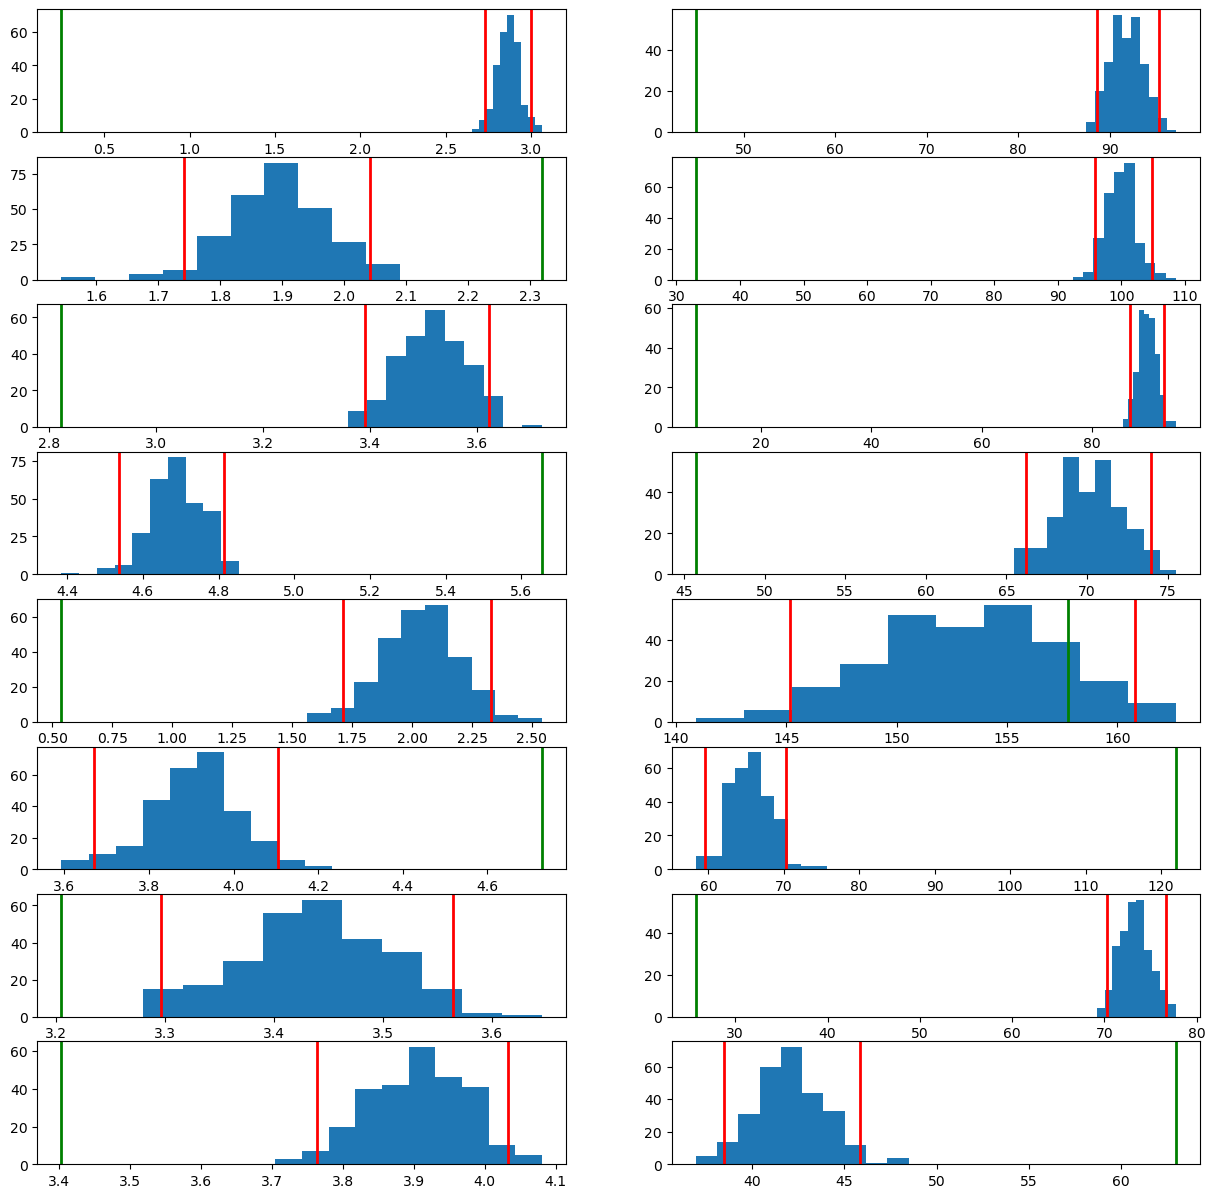

In [67]:
fig, axs = plt.subplots(8, 2,figsize=(15, 15))
# axs = axs.ravel()
# counter = 0
for idx, i in enumerate(random_idx):
    # print(counter)
    truth = y_valid_cur[i,:]
    preds = G_u_test[:, i,:]
    percts = np.percentile(preds, axis = 0, q = (2.5, 97.5))
    lis = percts[0,:]
    uis = percts[1,:]
    
    
    axs[idx, 0].hist(preds[:,0])
    axs[idx, 0].axvline(truth[0], color='green', linewidth=2)
    axs[idx, 0].axvline(lis[0], color='red', linewidth=2)
    axs[idx, 0].axvline(uis[0], color='red', linewidth=2)
    
    axs[idx, 1].hist(preds[:,1])
    axs[idx, 1].axvline(truth[1], color='green', linewidth=2)
    axs[idx, 1].axvline(lis[1], color='red', linewidth=2)
    axs[idx, 1].axvline(uis[1], color='red', linewidth=2)
    
    # counter+=2
    # print(counter)
    
    # plt.show()
plt.savefig('prediction_intervals.png', bbox_inches='tight')

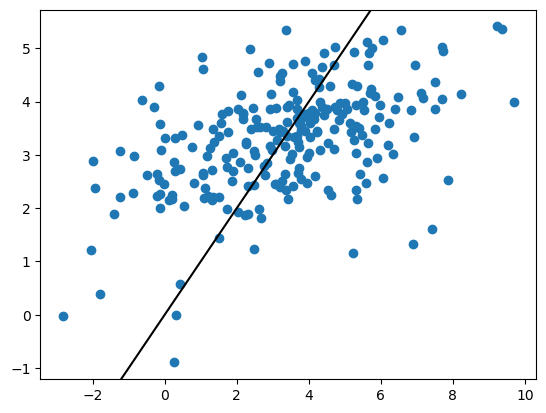

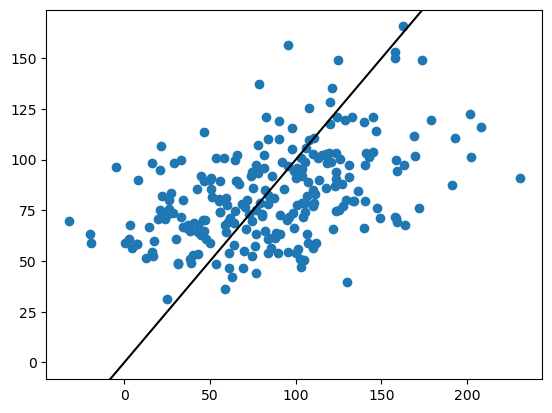

In [68]:
plt.scatter(y_valid_cur[:, 0], averaged_targets_test[:,0])
plt.axline((0,0), slope = 1, c= "black")
plt.show()
plt.scatter(y_valid_cur[:,1], averaged_targets_test[:, 1])
plt.axline((0,0), slope = 1, c= "black")
plt.show()

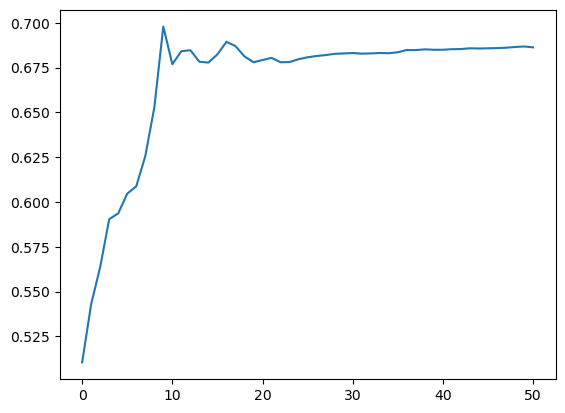

In [69]:
plt.plot(w1_catch)
plt.show()

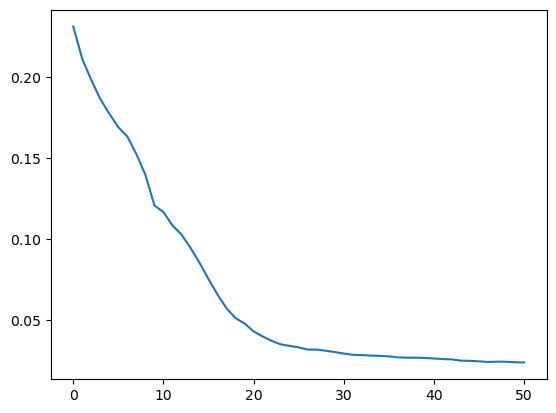

In [70]:
plt.plot(w1_sd_catch)
plt.show()


<ErrorbarContainer object of 3 artists>

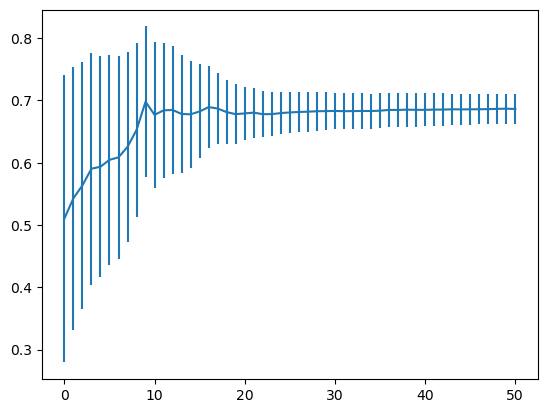

In [71]:
plt.errorbar(range(0, len(w1_catch)), w1_catch, w1_sd_catch)

<ErrorbarContainer object of 3 artists>

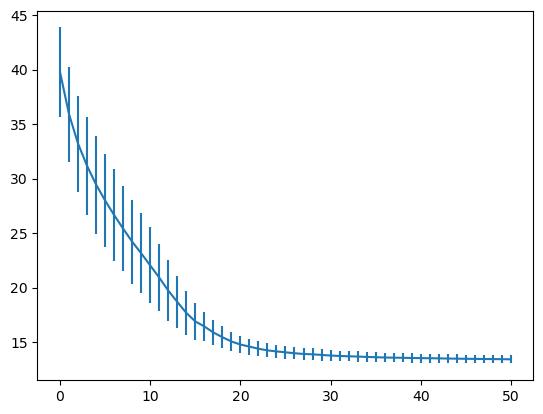

In [72]:
plt.errorbar(range(0, len(weight_norm_mean)), weight_norm_mean, weight_norm_sd)

In [73]:
cov_mat_final, _ = create_cov(smiles_feats_train.shape[0],initial_ensembles)

In [74]:
# R_t

In [75]:
np.cov(y_chk_full.values.T)

array([[   3.56194622,  -24.68021802],
       [ -24.68021802, 1862.41330966]])

In [76]:
best_R_t

array([[  0.95120805,  -7.78542461],
       [ -7.78542461, 697.71468329]])